In [132]:
# Import packages, access environment variables
import requests
from bs4 import BeautifulSoup
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
import collections    
import matplotlib.pyplot as plt   
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import nltk
nltk.download(["stopwords","vader_lexicon","punkt","wordnet"])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from numpy import asarray
from textblob import TextBlob
from dotenv import load_dotenv
import requests
import base64
from nrclex import NRCLex

url = "https://api.genius.com/search"

load_dotenv()

SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')
GENIUS_API_TOKEN = os.getenv('GENIUS_API_TOKEN')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ashren/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ashren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ashren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Web Scraping and Data Collection

In [89]:
# Get artist from Genius API
def get_artist_info(artist_name, page):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_url = base_url + '/search'
    params = {'q': artist_name, 'per_page': 10, 'page': page}
    
    response = requests.get(search_url, params=params, headers=headers)
    
    # Check if the response status is OK (200)
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        return None
    
    # Try parsing the response as JSON, handle cases where it's not JSON
    try:
        return response.json()
    except ValueError:
        print(f"Response was not JSON: {response.text}")
        return None

# Get all Genius.com song URLs for a specific artist
def get_song_urls(artist_name):
    page = 1
    songs = []
    
    while True:
        response = get_artist_info(artist_name, page)
        
        # If there's an issue with the response, break the loop
        if response is None:
            print("Failed to fetch data. Breaking the loop.")
            break
        
        song_info = []
        
        # Collect song objects for the artist
        for hit in response['response']['hits']:
            primary_artist = hit['result']['primary_artist']['name'].lower()
            
            # Ensure the artist name exactly matches the primary artist name
            if primary_artist == artist_name.lower():
                song_info.append(hit)
    
        # Collect song URLs from song objects
        for song in song_info:
            url = song['result']['url']
            songs.append(url)
            
        # If no more results, break the loop
        if len(song_info) == 0:
            break
        
        # Increase the page count to fetch the next batch of results
        page += 1
    
    return songs

song_urls = get_song_urls('Lorde')

In [90]:
# Get title and lyrics from each song
def scrape_song_info(song_urls):
    song_data = []

    for url in song_urls:
        try:
            # Make a request to the song URL
            page = requests.get(url)
            page.raise_for_status()  # Raise an exception for bad responses
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch {url}: {e}")
            song_data.append({'Song Title': 'Title Not Found', 'Lyrics': None})
            continue

        # Parse the HTML content with BeautifulSoup
        html = BeautifulSoup(page.text, 'html.parser')

        # Scrape the title
        title_tag = html.find('h1')
        if title_tag:
            title = title_tag.get_text().strip()
        else:
            title_tag = html.find('title')
            title = title_tag.get_text().split('|')[0].strip() if title_tag else "Title Not Found"

        # Scrape the lyrics
        lyrics_containers = html.find_all('div', class_=re.compile('Lyrics__Container'))
        lyrics = ' '.join([div.get_text(separator=" ").strip() for div in lyrics_containers])
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
        lyrics = ' '.join(lyrics.split()) if lyrics else None

        # Append the scraped data to the list
        song_data.append({'song_title': title, 'lyrics': lyrics})

    return song_data

# Example usage:
artist_name = 'Lorde'
song_urls = get_song_urls(artist_name)

# Scrape song titles and lyrics
song_info = scrape_song_info(song_urls)

# Convert the result to a DataFrame if needed
import pandas as pd
lorde_df = pd.DataFrame(song_info)

# View the resulting DataFrame
lorde_df


,song_title,lyrics
0,Royals,I've never seen a diamond in the flesh I cut m...
1,Team,Wait till you're announced We've not yet lost ...
2,Liability,"Go for it One, two Baby really hurt me, crying..."
3,Green Light,I do my makeup in somebody else's car We order...
4,Ribs,"The drink you spilt all over me ""Lover's Spit""..."
...,...,...
61,“Yellow Flicker Beat” Single Art,None
62,Te Ara Tika / The Path,I whānau mai au i te tau nihoroa I te kāinga M...
63,Perfect Places (Whethan Remix),"Every night, I live and die Feel the party to ..."
64,Invisible Ink*,Lyrics from Live Performance at Newquay Friend...


In [94]:
# Dropping rows with null values
lorde_df = lorde_df.dropna()
lorde_df.info()
lorde_df.isna()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 0 to 65
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_title  65 non-null     object
 1   lyrics      65 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


,song_title,lyrics
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
60,False,False
62,False,False
63,False,False
64,False,False


In [95]:
# Tokenize lyrics, remove punctuation, remove stop words

stop_words = stopwords.words('english')

def lyrics_tokenize(lyrics):
    # Tokenise words & ignore punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(lyrics)
    
    data_token=[token.lower() for token in tokens]
    processed_words= [w for w in data_token if not w in stop_words]
    return processed_words

lorde_df["tokenized_lyrics"] = [lyrics_tokenize(lyrics) for lyrics in lorde_df['lyrics']]
lorde_df.head()

,song_title,lyrics,tokenized_lyrics
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd..."
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou..."
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax..."
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different..."
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,..."


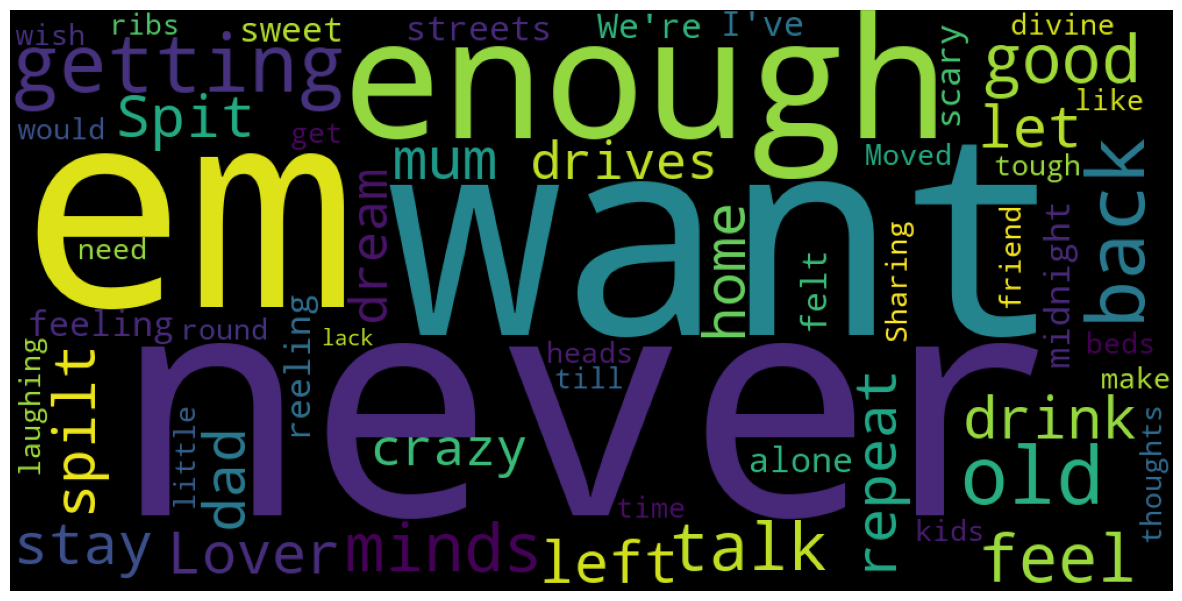

In [74]:
# Word cloud for Ribs

from collections import Counter

ribs_lyrics = lorde_df.loc[lorde_df['song_title']=="Ribs"]["lyrics"].values[0]

wordcloud = WordCloud(background_color='black', width = 1000, height = 500,collocations=False,random_state=100,stopwords=stop_words).generate(ribs_lyrics)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

# Generating word cloud image
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [97]:
# Turn column into string in order to apply polarity scores
lorde_df['new_tokenized_lyrics'] = [' '.join(map(str, l)) for l in lorde_df['tokenized_lyrics']]
lorde_df['sentiment'] = lorde_df['new_tokenized_lyrics'].apply(lambda lyric: TextBlob(lyric).sentiment)

# Processed song TEXTBLOB sentiment analysis
lorde_df['sentiment'] = lorde_df['new_tokenized_lyrics'].apply(lambda lyric: TextBlob(lyric).sentiment)
lorde_df.head(1)

# Split sentiment column into polarity and subjectivity
lorde_df['polarity'] = lorde_df['sentiment'].str.get(0)
lorde_df['subjectivity'] = lorde_df['sentiment'].str.get(1)
lorde_df = lorde_df.drop("sentiment", axis = 1)

lorde_df['sentiment'] = ''
lorde_df.loc[lorde_df.polarity > 0, 'sentiment'] = 'positive'
lorde_df.loc[lorde_df.polarity == 0, 'sentiment'] = 'neutral'
lorde_df.loc[lorde_df.polarity < 0, 'sentiment'] = 'negative'


lorde_df

,song_title,lyrics,tokenized_lyrics,new_tokenized_lyrics,polarity,subjectivity,sentiment
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd...",never seen diamond flesh cut teeth wedding rin...,0.360262,0.638636,positive
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou...",wait till announced yet lost graces hounds sta...,0.268788,0.610000,positive
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax...",go one two baby really hurt crying taxi wanna ...,0.116111,0.418056,positive
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different...",makeup somebody else car order different drink...,0.177172,0.507980,positive
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,...",drink spilt lover spit left repeat mum dad let...,-0.009824,0.444309,negative
...,...,...,...,...,...,...,...
60,Team (HBK Gang Remix),Wait 'til you're announced We've not yet lost ...,"[wait, til, announced, yet, lost, graces, houn...",wait til announced yet lost graces hounds stay...,0.176569,0.583452,positive
62,Te Ara Tika / The Path,I whānau mai au i te tau nihoroa I te kāinga M...,"[whānau, mai, au, te, tau, nihoroa, te, kāinga...",whānau mai au te tau nihoroa te kāinga moepapa...,0.000000,0.000000,neutral
63,Perfect Places (Whethan Remix),"Every night, I live and die Feel the party to ...","[every, night, live, die, feel, party, bones, ...",every night live die feel party bones watch wa...,0.293636,0.670000,positive
64,Invisible Ink*,Lyrics from Live Performance at Newquay Friend...,"[lyrics, live, performance, newquay, friends, ...",lyrics live performance newquay friends mine p...,-0.066076,0.517143,negative


In [98]:
# Encode client ID and client secret for the Authorization header
client_creds = f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}"
client_creds_b64 = base64.b64encode(client_creds.encode()).decode()

# URL to request the access token
token_url = 'https://accounts.spotify.com/api/token'

# Headers and body for the token request
headers = {
    "Authorization": f"Basic {client_creds_b64}",
    "Content-Type": "application/x-www-form-urlencoded"
}
data = {
    "grant_type": "client_credentials"
}

# Send POST request to get the access token
response = requests.post(token_url, headers=headers, data=data)
token_response = response.json()

# Extract the access token
access_token = token_response.get('access_token')


In [99]:
# Spotify API base URL
base_url = "https://api.spotify.com/v1"

# Function to search for a track by name and artist
def search_track(access_token, track_name, artist_name):
    search_url = f"{base_url}/search"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    params = {
        "q": f"track:{track_name} artist:{artist_name}",
        "type": "track",
        "limit": 1 
    }
    
    response = requests.get(search_url, headers=headers, params=params)
    search_result = response.json()
    
    if search_result.get('tracks') and search_result['tracks']['items']:
        track = search_result['tracks']['items'][0]
        return track['id']
    else:
        return None


In [100]:
# Function to get audio features for a track by ID
def get_audio_features(access_token, track_id):
    audio_features_url = f"{base_url}/audio-features/{track_id}"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    response = requests.get(audio_features_url, headers=headers)
    features = response.json()
    
    return features

In [101]:
song_titles = [list(d.values())[0] for d in song_info]
audio_features_collection = {}
unavailable_tracks = []

# Create list of songs that are not in Spotify
for song in song_titles:
    if search_track(access_token, song, 'Lorde') is None:
        unavailable_tracks.append(song)

songs_on_spotify = [song for song in song_titles if song not in unavailable_tracks]

# Extract audio features for each song
for song in songs_on_spotify:
    track_id = search_track(access_token, song, 'Lorde')
    if track_id:
        audio_features = get_audio_features(access_token, track_id)
        audio_features_collection[song]=audio_features

In [102]:
unavailable_tracks

['Royals (Rick Ross Remix)',
 'Precious Metals',
 'Good Fights',
 'Royals (The Elite Remix)',
 'Lost Boys',
 'Heartbreaking Love',
 'Silver Moon*',
 'Hold My Liquor',
 'Team (HBK Gang Remix)',
 '“Yellow Flicker Beat” Single Art',
 'Perfect Places (Whethan Remix)',
 'Invisible Ink*',
 'Sweet Dreams (Are Made of This)']

In [104]:
# Remove rows from the data frame if the song does not exist in Spotify

lorde_df = lorde_df[lorde_df['song_title'].isin(songs_on_spotify)]

# Check if the songs in the dataframe are in the same order as the songs in the audio features collection
print(lorde_df['song_title'].tolist() == list(audio_features_collection.keys()))

lorde_df


True


,song_title,lyrics,tokenized_lyrics,new_tokenized_lyrics,polarity,subjectivity,sentiment
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd...",never seen diamond flesh cut teeth wedding rin...,0.360262,0.638636,positive
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou...",wait till announced yet lost graces hounds sta...,0.268788,0.610000,positive
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax...",go one two baby really hurt crying taxi wanna ...,0.116111,0.418056,positive
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different...",makeup somebody else car order different drink...,0.177172,0.507980,positive
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,...",drink spilt lover spit left repeat mum dad let...,-0.009824,0.444309,negative
5,The Louvre,"Well, summer slipped us underneath her tongue ...","[well, summer, slipped, us, underneath, tongue...",well summer slipped us underneath tongue days ...,0.050000,0.509259,positive
6,Hard Feelings/Loveless,"Go back and tell it Please, could you be tende...","[go, back, tell, please, could, tender, sit, c...",go back tell please could tender sit close let...,0.033600,0.563440,positive
7,Tennis Court,Don't you think that it's Boring how people ta...,"[think, boring, people, talk, making, smart, w...",think boring people talk making smart words we...,0.127697,0.605688,positive
8,Perfect Places,"Every night, I live and die Feel the party to ...","[every, night, live, die, feel, party, bones, ...",every night live die feel party bones watch wa...,0.372727,0.695652,positive
9,Solar Power,"I hate the winter, can't stand the cold I tend...","[hate, winter, stand, cold, tend, cancel, plan...",hate winter stand cold tend cancel plans heat ...,-0.046116,0.662645,negative


In [117]:
# Remove remixes, songs in non-English languages
# lorde_df = lorde_df[~lorde_df['song_title'].str.contains('Remix')]
# lorde_df = lorde_df.reset_index()
# lorde_df = lorde_df.drop(["index"], axis=1)
# lorde_df = lorde_df.drop([47, 48])
lorde_df


,song_title,lyrics,tokenized_lyrics,new_tokenized_lyrics,polarity,subjectivity,sentiment
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd...",never seen diamond flesh cut teeth wedding rin...,0.360262,0.638636,positive
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou...",wait till announced yet lost graces hounds sta...,0.268788,0.610000,positive
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax...",go one two baby really hurt crying taxi wanna ...,0.116111,0.418056,positive
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different...",makeup somebody else car order different drink...,0.177172,0.507980,positive
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,...",drink spilt lover spit left repeat mum dad let...,-0.009824,0.444309,negative
5,The Louvre,"Well, summer slipped us underneath her tongue ...","[well, summer, slipped, us, underneath, tongue...",well summer slipped us underneath tongue days ...,0.050000,0.509259,positive
6,Hard Feelings/Loveless,"Go back and tell it Please, could you be tende...","[go, back, tell, please, could, tender, sit, c...",go back tell please could tender sit close let...,0.033600,0.563440,positive
7,Tennis Court,Don't you think that it's Boring how people ta...,"[think, boring, people, talk, making, smart, w...",think boring people talk making smart words we...,0.127697,0.605688,positive
8,Perfect Places,"Every night, I live and die Feel the party to ...","[every, night, live, die, feel, party, bones, ...",every night live die feel party bones watch wa...,0.372727,0.695652,positive
9,Solar Power,"I hate the winter, can't stand the cold I tend...","[hate, winter, stand, cold, tend, cancel, plan...",hate winter stand cold tend cancel plans heat ...,-0.046116,0.662645,negative


In [118]:
# Extract every audio feature and insert into dataframe
danceability = [audio_features_collection[song]['danceability'] for song in lorde_df['song_title']]
energy = [audio_features_collection[song]['energy'] for song in lorde_df['song_title']]
key = [audio_features_collection[song]['key'] for song in lorde_df['song_title']]
loudness = [audio_features_collection[song]['loudness'] for song in lorde_df['song_title']]
speechiness = [audio_features_collection[song]['speechiness'] for song in lorde_df['song_title']]
acousticness = [audio_features_collection[song]['acousticness'] for song in lorde_df['song_title']]
instrumentalness = [audio_features_collection[song]['instrumentalness'] for song in lorde_df['song_title']]
liveness = [audio_features_collection[song]['liveness'] for song in lorde_df['song_title']]
valence = [audio_features_collection[song]['valence'] for song in lorde_df['song_title']]
tempo = [audio_features_collection[song]['tempo'] for song in lorde_df['song_title']]

lorde_df['danceability'] = danceability
lorde_df['energy'] = energy
lorde_df['key'] = key
lorde_df['loudness'] = loudness
lorde_df['speechiness'] = speechiness
lorde_df['acousticness'] = acousticness
lorde_df['instrumentalness'] = instrumentalness
lorde_df['liveness'] = liveness
lorde_df['valence'] = valence
lorde_df['tempo'] = tempo


In [119]:
# Function to extract emotion scores
def get_emotion_scores(lyrics):
    emotion = NRCLex(lyrics)
    return emotion.raw_emotion_scores

# Apply to the dataframe
lorde_df['emotion_scores'] = lorde_df['lyrics'].apply(get_emotion_scores)


# Expand the emotion scores dictionary into separate columns
emotion_df = pd.json_normalize(lorde_df['emotion_scores'])

# Combine the new emotion columns with the original DataFrame
lorde_df = pd.concat([lorde_df, emotion_df], axis=1)

# Display the updated DataFrame
lorde_df = lorde_df.drop('emotion_scores', axis=1)



In [125]:
# Display the updated DataFrame
lorde_df.head()

,song_title,lyrics,tokenized_lyrics,new_tokenized_lyrics,polarity,subjectivity,sentiment,danceability,energy,key,...,joy,positive,disgust,anticipation,trust,fear,anger,negative,surprise,sadness
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd...",never seen diamond flesh cut teeth wedding rin...,0.360262,0.638636,positive,0.674,0.426,7,...,16.0,22.0,1.0,8.0,12.0,10,5.0,1,1.0,0.0
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou...",wait till announced yet lost graces hounds sta...,0.268788,0.610000,positive,0.691,0.578,6,...,9.0,11.0,0.0,3.0,14.0,2,0.0,4,0.0,5.0
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax...",go one two baby really hurt crying taxi wanna ...,0.116111,0.418056,positive,0.587,0.229,10,...,10.0,13.0,1.0,9.0,8.0,10,4.0,12,9.0,8.0
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different...",makeup somebody else car order different drink...,0.177172,0.507980,positive,0.594,0.721,2,...,20.0,28.0,3.0,0.0,15.0,4,2.0,8,3.0,3.0
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,...",drink spilt lover spit left repeat mum dad let...,-0.009824,0.444309,negative,0.525,0.472,4,...,14.0,18.0,3.0,12.0,12.0,9,6.0,12,10.0,8.0


# Exploratory Data Analysis

In [121]:
lorde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   song_title            47 non-null     object 
 1   lyrics                47 non-null     object 
 2   tokenized_lyrics      47 non-null     object 
 3   new_tokenized_lyrics  47 non-null     object 
 4   polarity              47 non-null     float64
 5   subjectivity          47 non-null     float64
 6   sentiment             47 non-null     object 
 7   danceability          47 non-null     float64
 8   energy                47 non-null     float64
 9   key                   47 non-null     int64  
 10  loudness              47 non-null     float64
 11  speechiness           47 non-null     float64
 12  acousticness          47 non-null     float64
 13  instrumentalness      47 non-null     float64
 14  liveness              47 non-null     float64
 15  valence               47 

In [122]:
# Replacing null values with 0
lorde_df = lorde_df.fillna(0)

In [123]:
lorde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   song_title            47 non-null     object 
 1   lyrics                47 non-null     object 
 2   tokenized_lyrics      47 non-null     object 
 3   new_tokenized_lyrics  47 non-null     object 
 4   polarity              47 non-null     float64
 5   subjectivity          47 non-null     float64
 6   sentiment             47 non-null     object 
 7   danceability          47 non-null     float64
 8   energy                47 non-null     float64
 9   key                   47 non-null     int64  
 10  loudness              47 non-null     float64
 11  speechiness           47 non-null     float64
 12  acousticness          47 non-null     float64
 13  instrumentalness      47 non-null     float64
 14  liveness              47 non-null     float64
 15  valence               47 

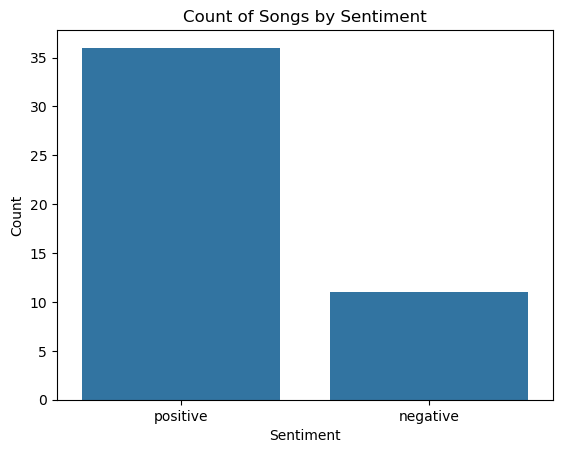

In [124]:
# Bar Plot of sentiments
sentiment_counts = lorde_df['sentiment'].value_counts()

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Songs by Sentiment')
plt.show()

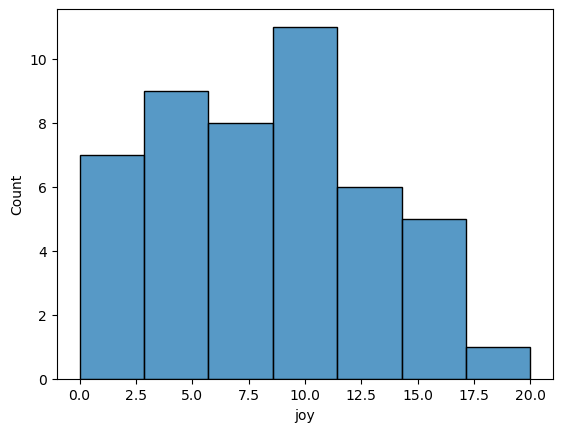

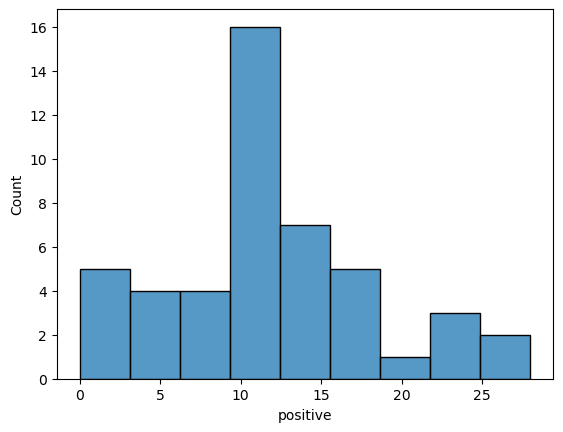

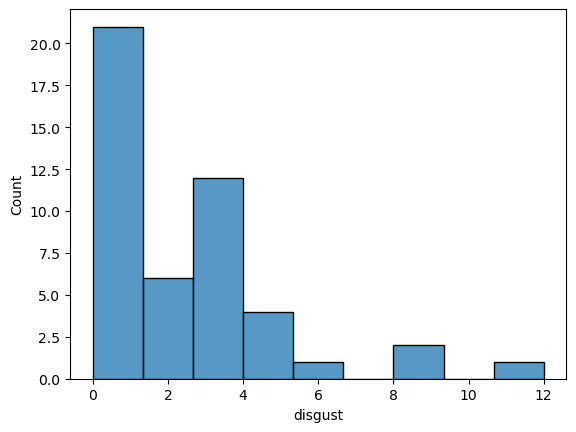

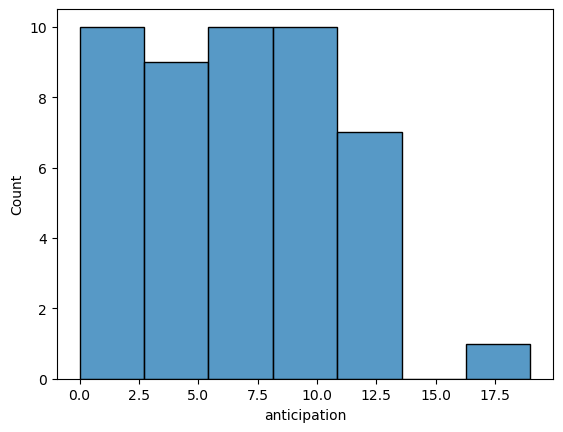

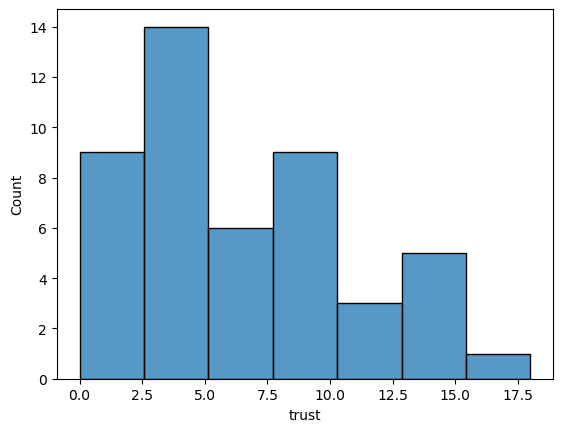

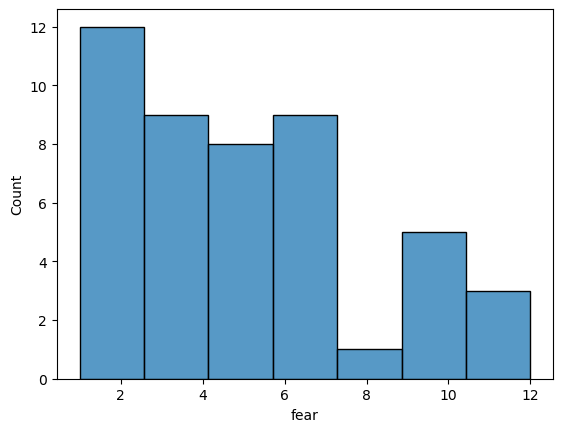

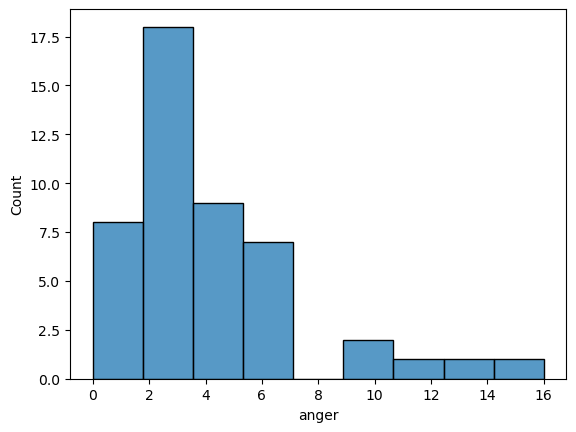

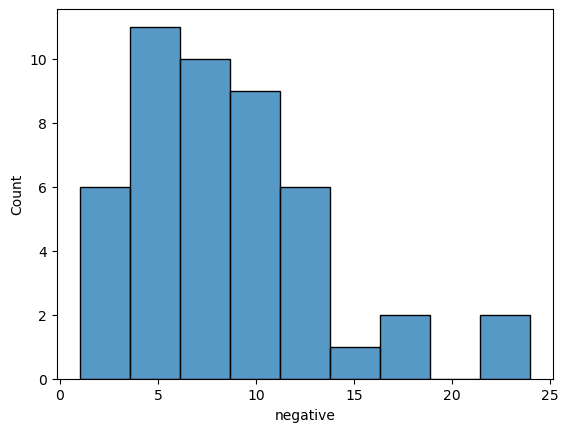

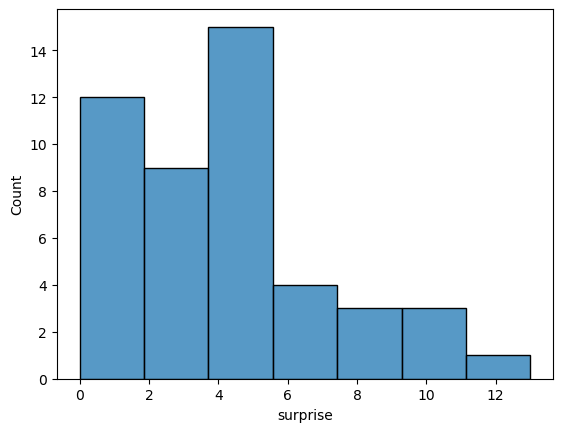

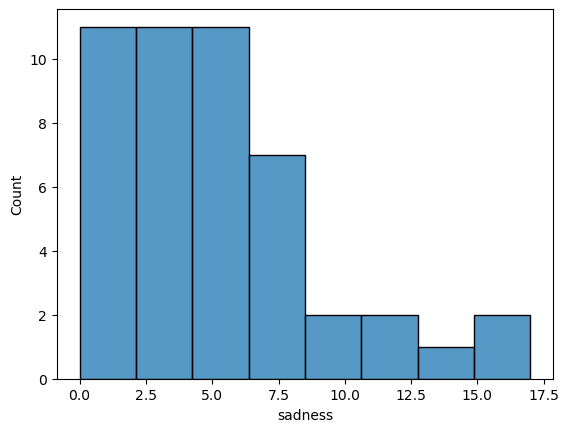

In [134]:
# Histogram of counts for each emotion
for emotion in ["joy", "positive", "disgust", "anticipation", "trust", "fear", "anger", "negative", "surprise", "sadness"]:
    sns.histplot(x=lorde_df[emotion])
    plt.show()


<Axes: >

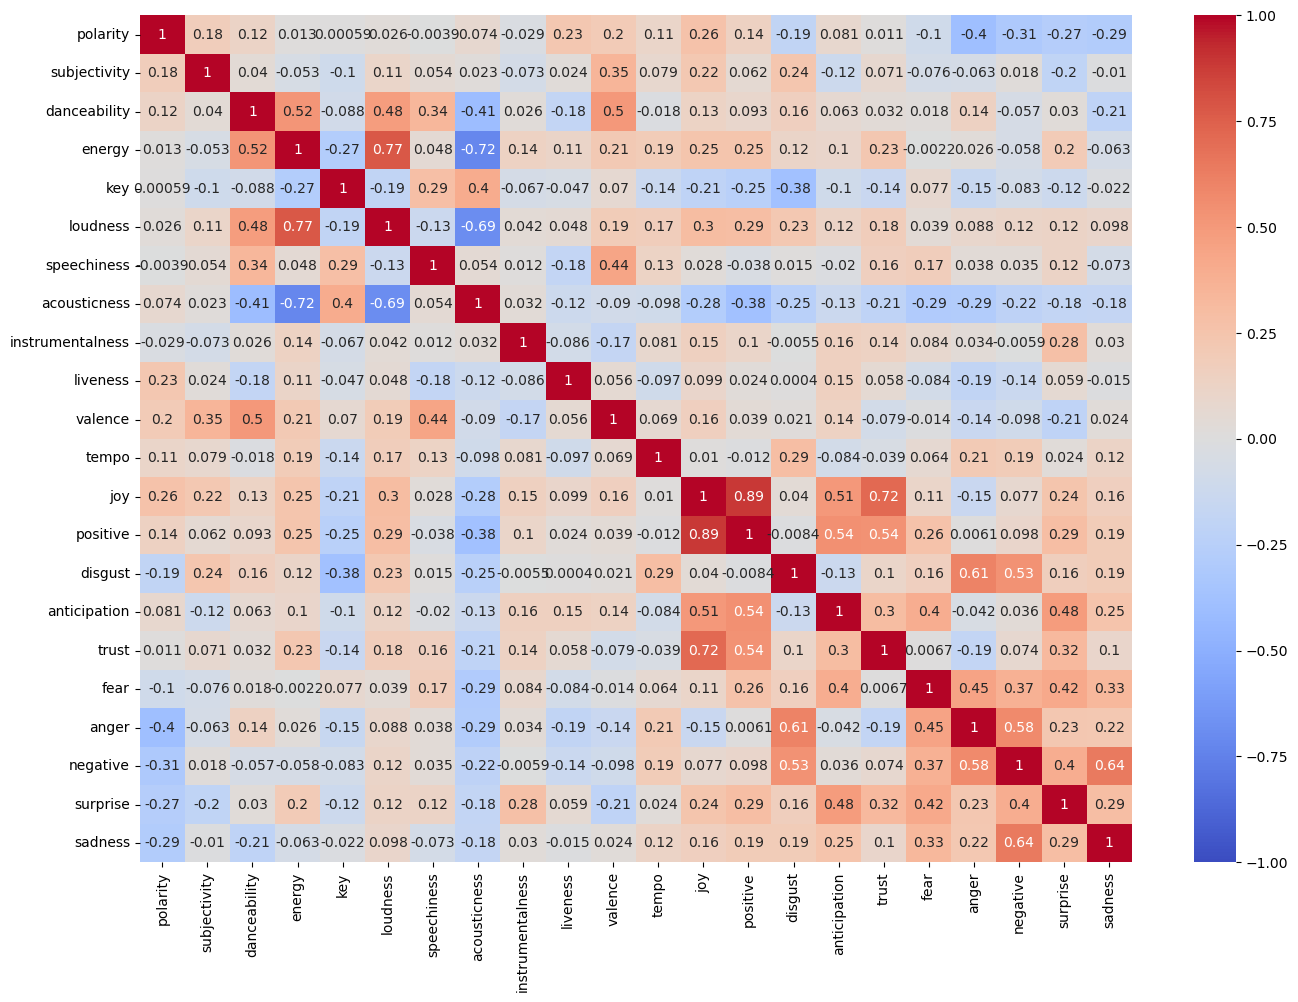

In [147]:
# Correlation heatmap for the numeric variables
numeric_cols = lorde_df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(16, 11))
sns.heatmap(lorde_df[numeric_cols].corr(), annot=True, vmin = -1, cmap='coolwarm')

In [160]:
# K-means clustering
from sklearn.cluster import KMeans

numeric = lorde_df[numeric_cols]

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(numeric)
    wcss.append(kmeans.inertia_)


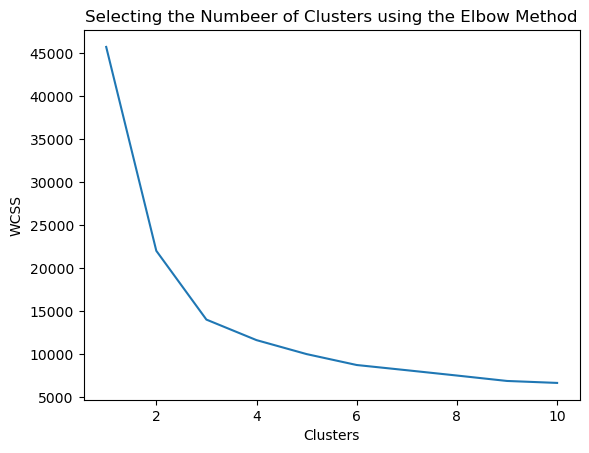

In [161]:
plt.plot(range(1, 11), wcss)
plt.title('Selecting the Numbeer of Clusters using the Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

In [165]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

# Fit the model and predict cluster labels for the data
cluster_labels = kmeans.fit_predict(numeric)

# Add the cluster labels to the dataframe
numeric['cluster'] = cluster_labels

/var/folders/vv/2tyv9bm12sz47cjgm0593wqc0000gn/T/ipykernel_20408/1132474074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric['cluster'] = cluster_labels


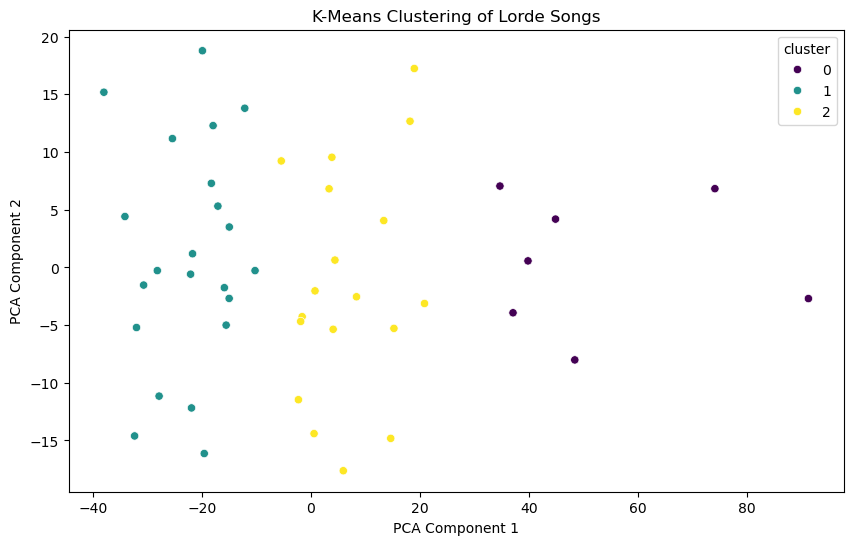

In [163]:
from sklearn.decomposition import PCA

# Reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(numeric)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=lorde_df['cluster'], palette='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering of Lorde Songs')
plt.show()

In [176]:
cluster_summary = numeric.groupby('cluster').mean()
cluster_summary.iloc[0, :]

polarity              0.154676
subjectivity          0.526329
danceability          0.578571
energy                0.415286
key                   5.000000
loudness             -9.705714
speechiness           0.101157
acousticness          0.543757
instrumentalness      0.000498
liveness              0.154986
valence               0.409671
tempo               162.847286
joy                   8.571429
positive             12.000000
disgust               3.428571
anticipation          8.142857
trust                 5.857143
fear                  6.000000
anger                 4.857143
negative              9.857143
surprise              4.142857
sadness               6.428571
Name: 0, dtype: float64

In [180]:
cluster_summary.iloc[1, :]

polarity             0.106682
subjectivity         0.493587
danceability         0.584955
energy               0.393386
key                  4.818182
loudness           -10.519636
speechiness          0.065877
acousticness         0.524745
instrumentalness     0.003938
liveness             0.173223
valence              0.326691
tempo               87.681773
joy                  8.636364
positive            12.727273
disgust              1.272727
anticipation         7.863636
trust                6.727273
fear                 5.272727
anger                3.045455
negative             7.045455
surprise             4.045455
sadness              5.136364
Name: 1, dtype: float64

In [178]:
cluster_summary.iloc[2, :]

polarity              0.121216
subjectivity          0.490672
danceability          0.581000
energy                0.450278
key                   3.666667
loudness             -9.837167
speechiness           0.062000
acousticness          0.449684
instrumentalness      0.053596
liveness              0.160833
valence               0.187561
tempo               116.533833
joy                   7.388889
positive             10.944444
disgust               3.111111
anticipation          4.444444
trust                 6.944444
fear                  4.500000
anger                 4.944444
negative              9.944444
surprise              3.888889
sadness               5.444444
Name: 2, dtype: float64

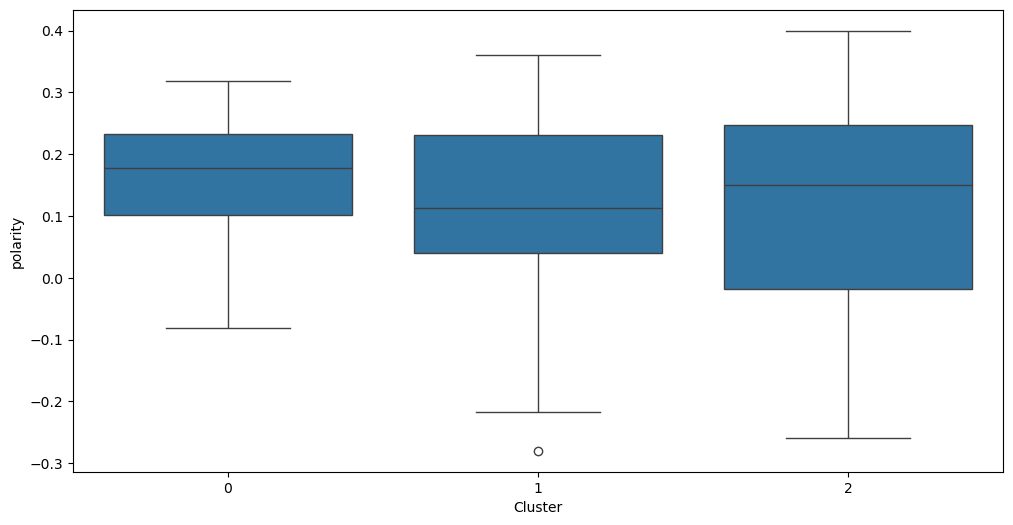

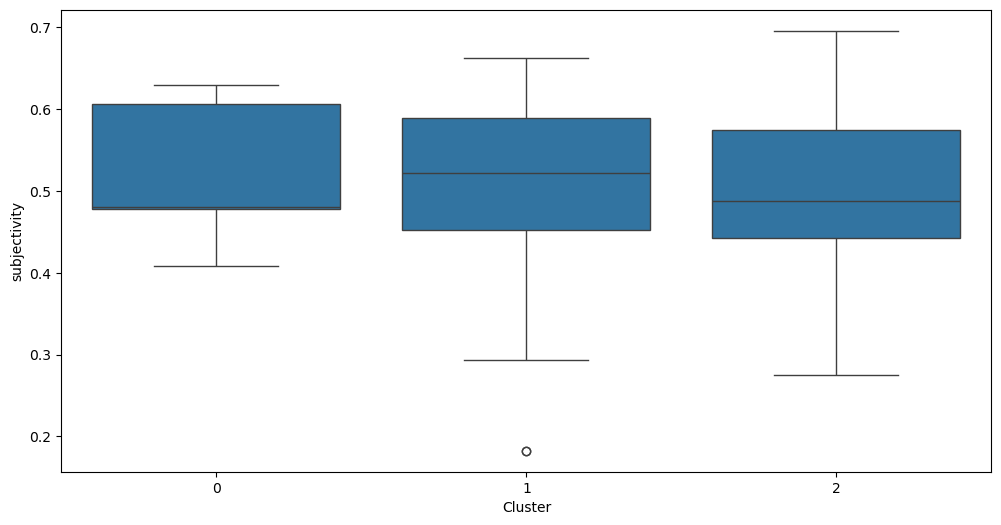

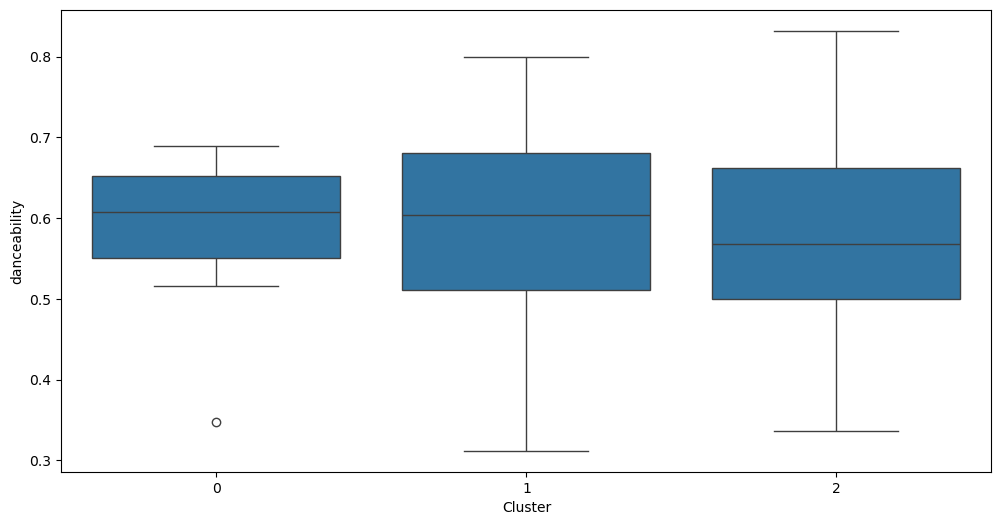

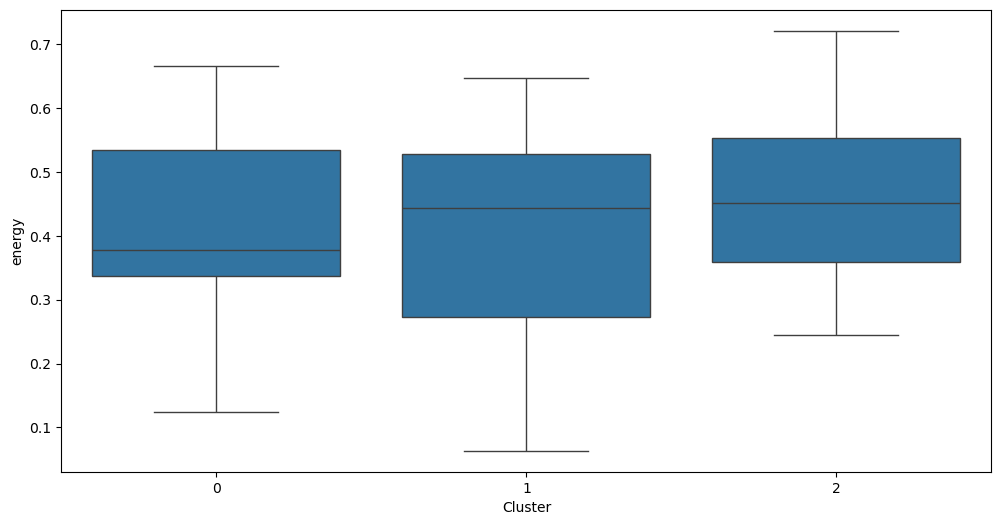

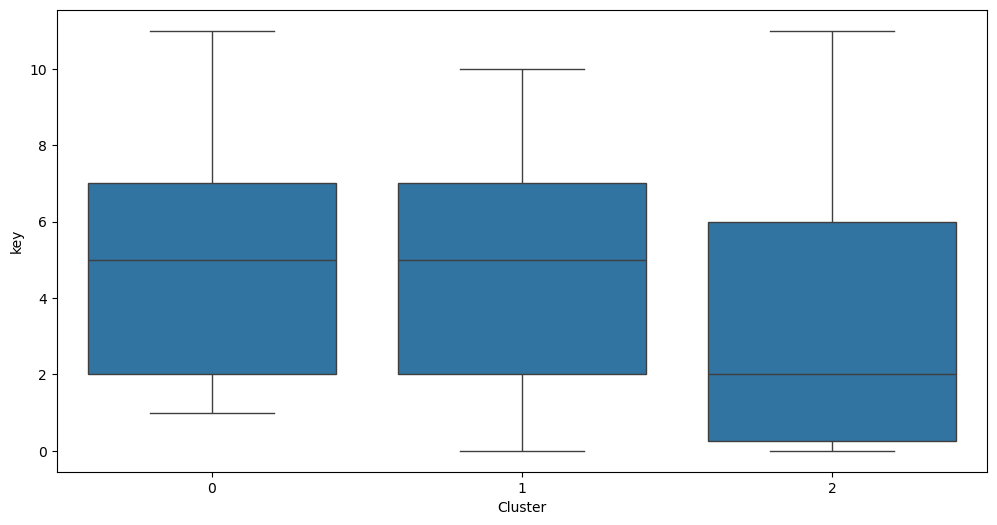

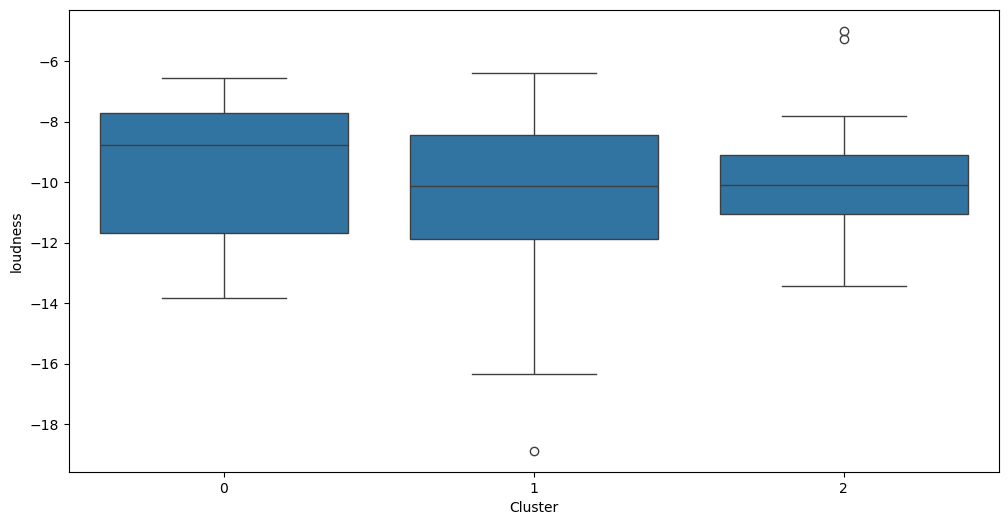

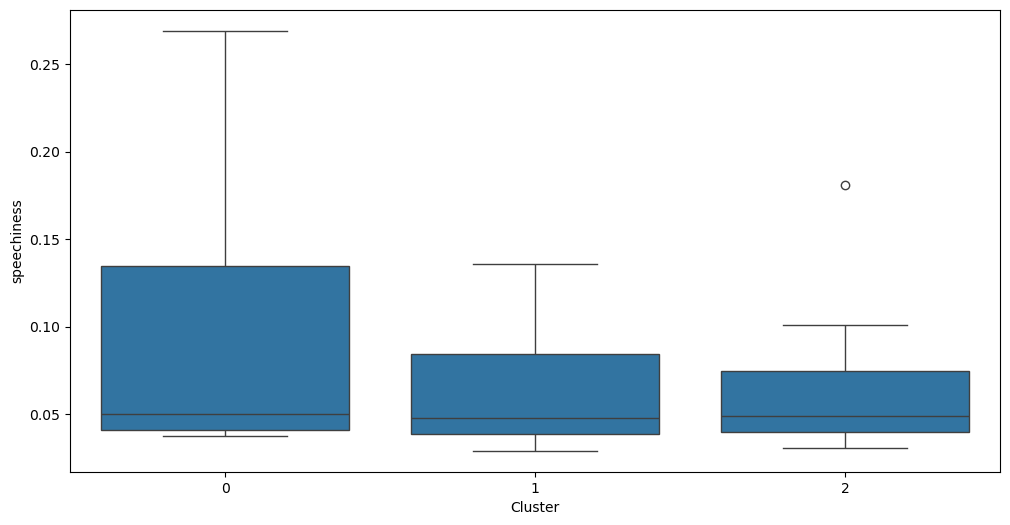

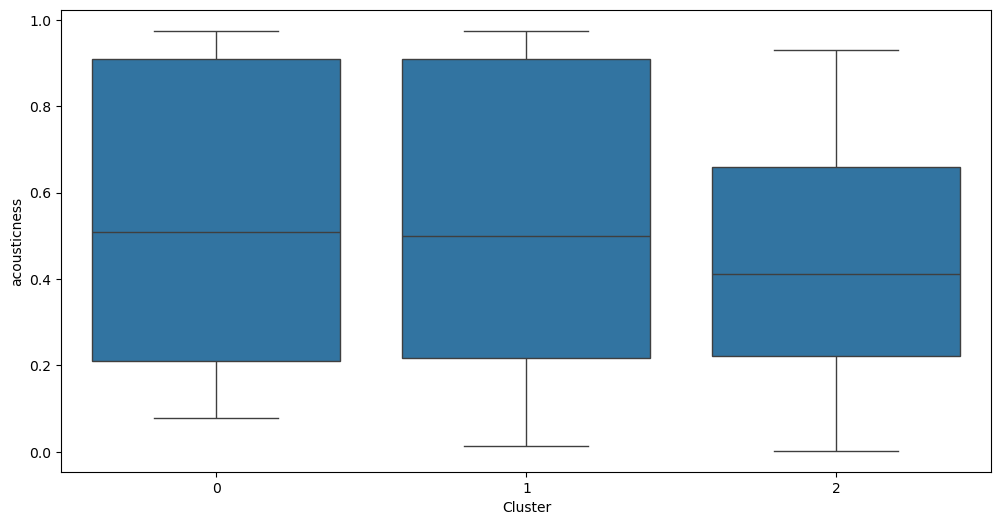

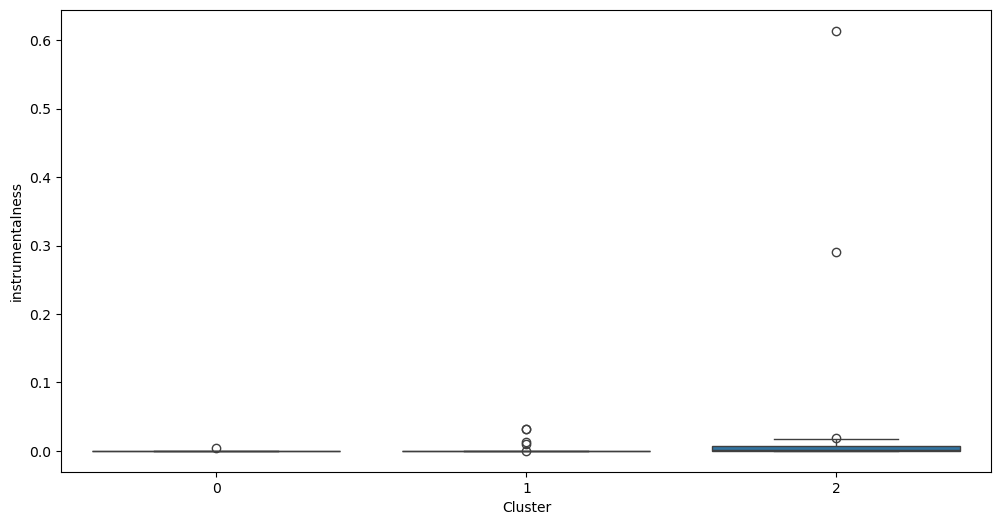

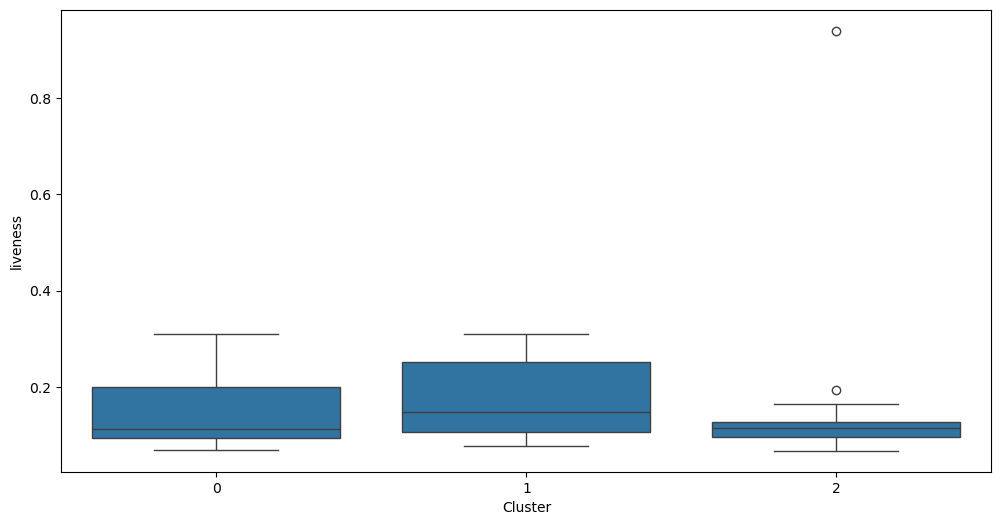

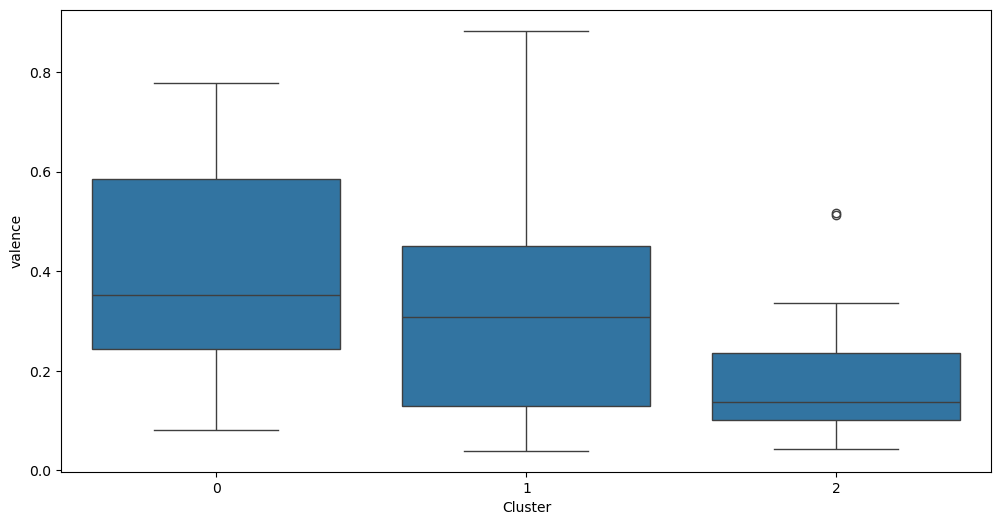

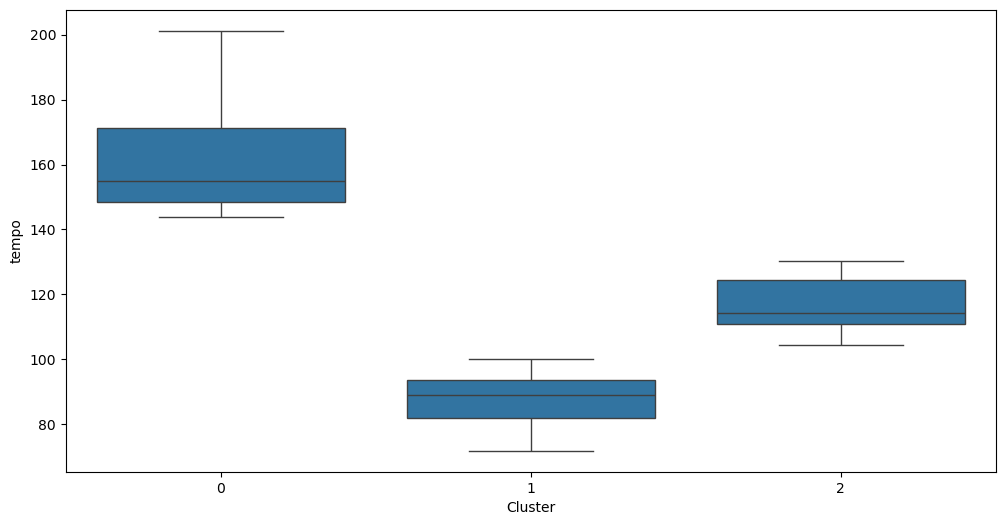

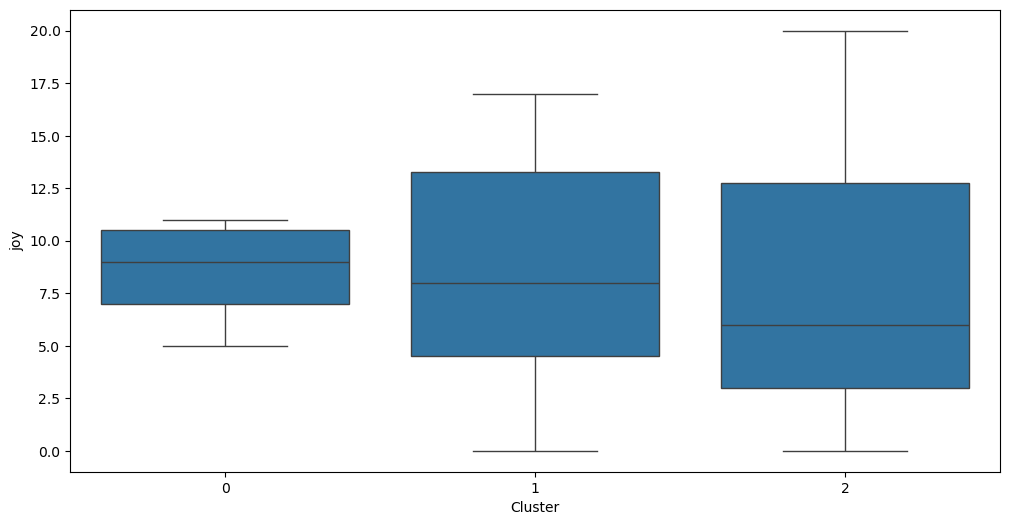

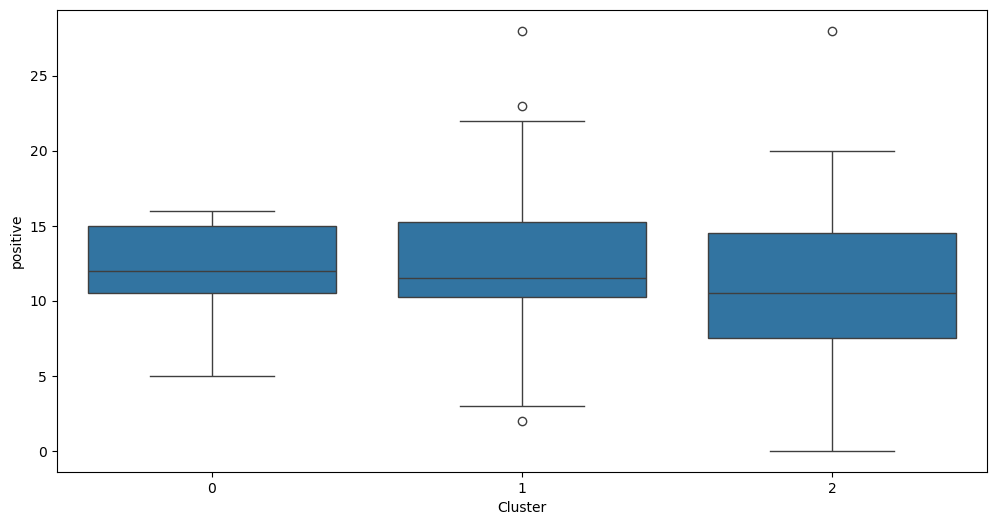

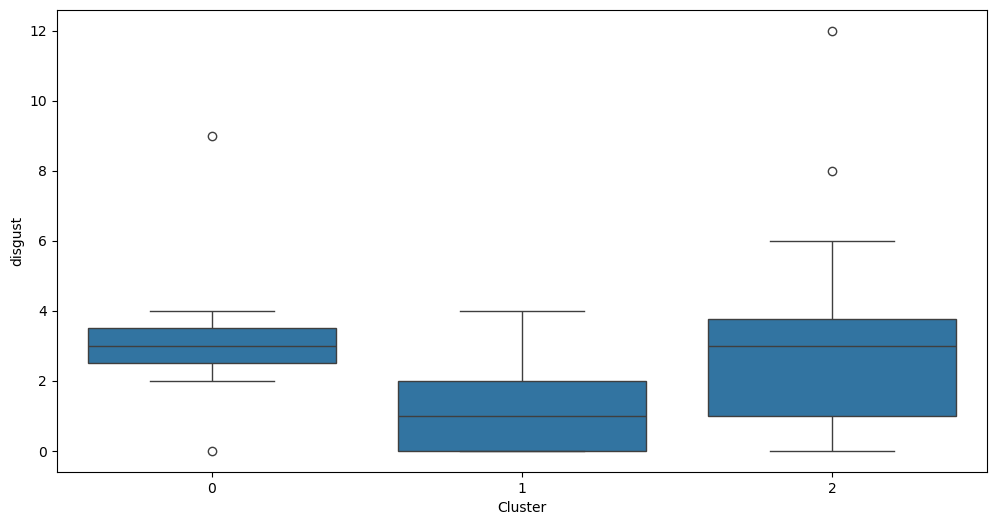

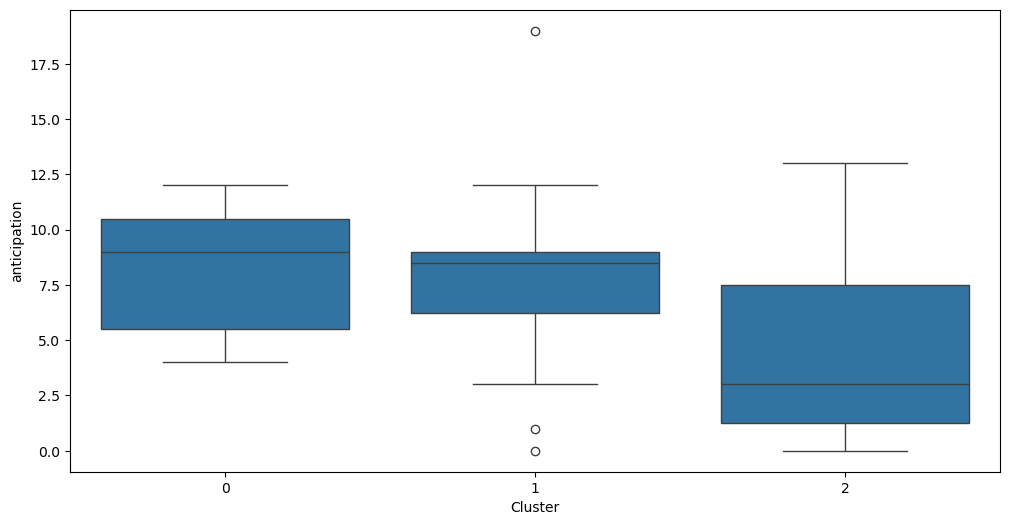

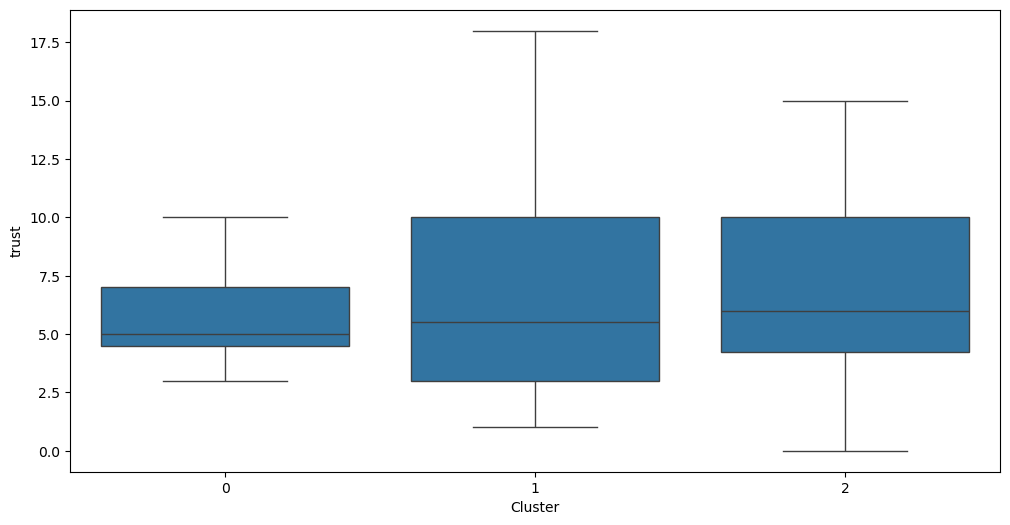

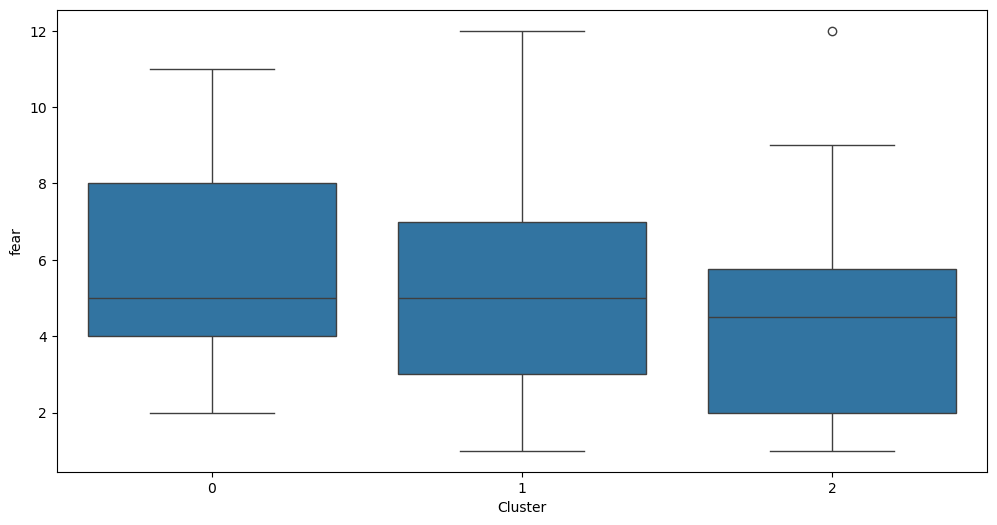

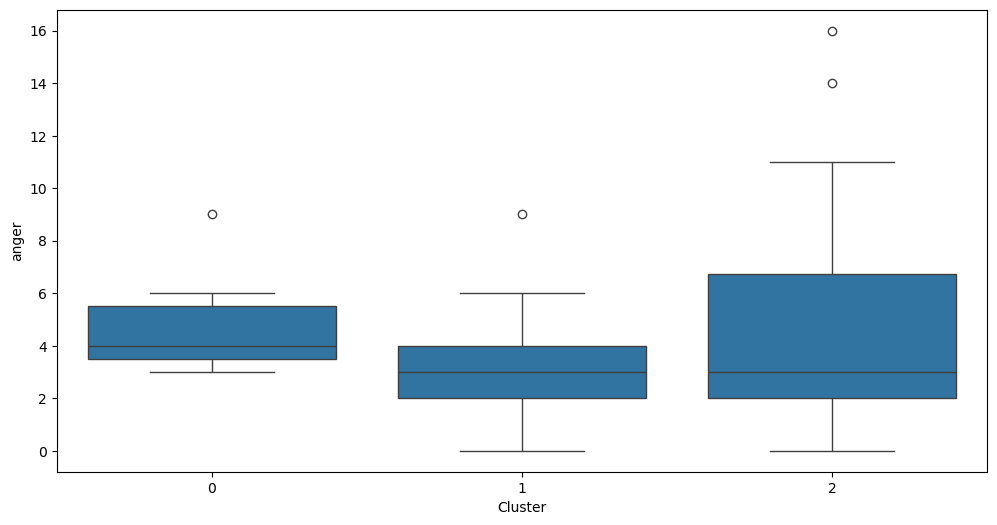

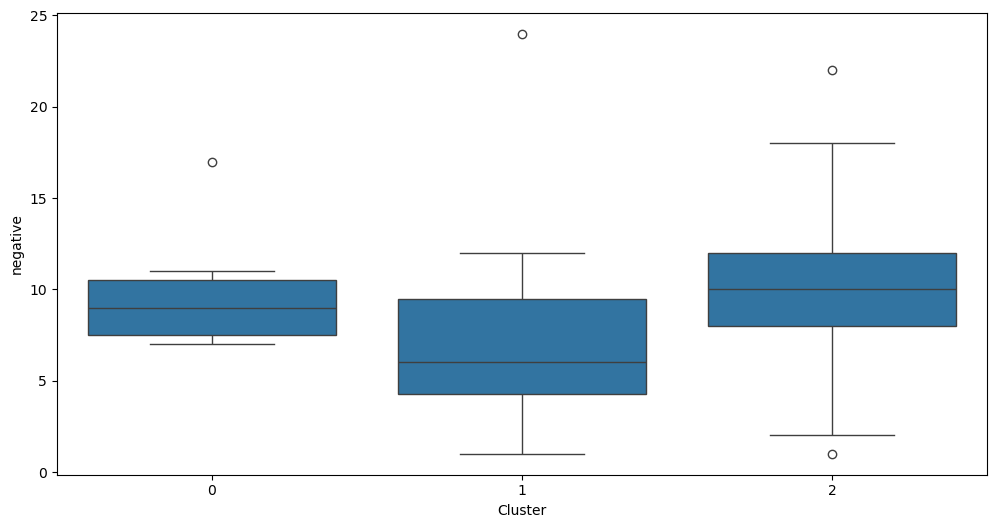

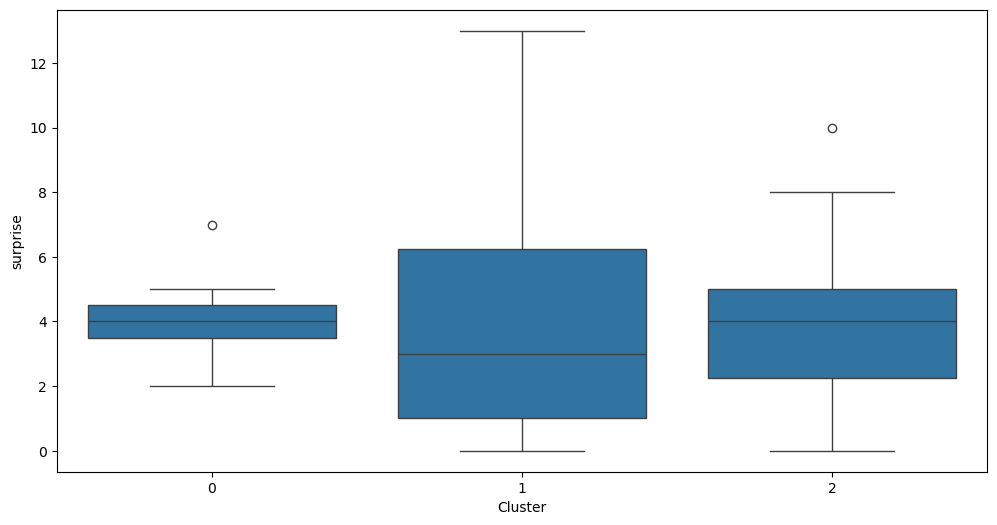

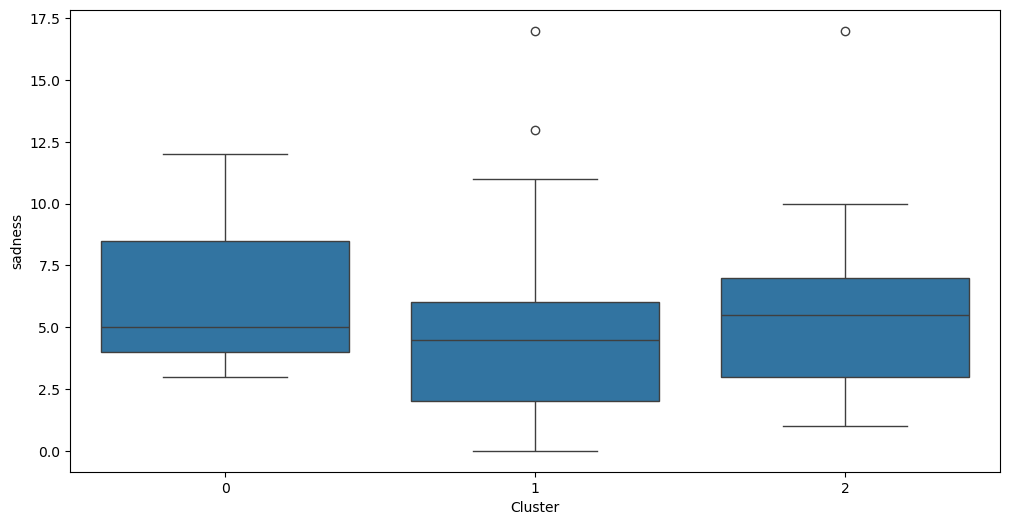

In [185]:
for metric in numeric_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cluster', y=metric, data=numeric)
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.show()
